In [7]:
import sys
import ray
import time
import math
import os


In [8]:
ray.init()

2022-07-26 23:32:35,628	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '172.28.6.160',
 'raylet_ip_address': '172.28.6.160',
 'redis_address': '172.28.6.160:6379',
 'object_store_address': '/tmp/ray/session_2022-07-26_23-32-35_146553_37707/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-07-26_23-32-35_146553_37707/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2022-07-26_23-32-35_146553_37707',
 'metrics_export_port': 60383,
 'node_id': '1586b34fa8edaba7ad876283501ca54c33f9f528'}

In [591]:
prefix = ""
traffic_config_template = {
    "wkld" : "FbHdp_distribution",
    "nhost" : 64,
    "load" : 0.6,
    "time_s" : 0.1,
    "incast" : 0,
    "pattern" : 0
}

cc_config_template = { 
    "cc" : "",
    "slow_unit" : 0,
    "ack_highprio" : 1,
    "abc_dt" : 0,
    "abc_delta" : 12000, 
    "abc_token" : 50,
    "abc_eta" : 0.95,
    "utgt" : 95
}
@ray.remote
def launch(trace, cc_config):
    cc = cc_config['cc'] 
    slow_unit = cc_config['slow_unit'] 
    ack_highprio = cc_config['ack_highprio']
    abc_dt = cc_config['abc_dt']
    abc_delta = cc_config['abc_delta']
    abc_token = cc_config['abc_token']
    abc_eta = cc_config['abc_eta']
    utgt = cc_config['utgt']
    
    work_dir = "/home/cxyzhao/High-Precision-Congestion-Control/simulation"
    os.chdir(work_dir)
    print("python run.py --c {} --trace {}  --bw 100 --topo 2layer --hpai 80 --slow_unit {} --ack_highprio {} --abc_dt {}  --abc_delta {} --abc_token {} --abc_eta {} --utgt {}".format(cc, trace, slow_unit, ack_highprio, abc_dt, abc_delta, abc_token, abc_eta, utgt))
    os.system("python run.py --c {} --trace {}  --bw 100 --topo 2layer --hpai 80 --slow_unit {} --ack_highprio {} --abc_dt {}  --abc_delta {} --abc_token {} --abc_eta {} --utgt {}".format(cc, trace, slow_unit, ack_highprio, abc_dt, abc_delta, abc_token, abc_eta, utgt))


def gen_trafic_config(traffic_config):
    wkld = traffic_config['wkld']
    nhost = traffic_config['nhost']
    load = traffic_config['load']
    time_s = traffic_config['time_s']
    incast = traffic_config['incast']
    pattern = traffic_config['pattern'] 
    work_dir = "/home/cxyzhao/High-Precision-Congestion-Control/traffic_gen"
    os.chdir(work_dir)
    output_name = "{}_n{}_load{}_t{}_incast{}_pattern{}".format(wkld, nhost, load, time_s, incast, pattern)
    
    #Check if requried file already exist
    dataset_files = os.listdir("/home/cxyzhao/High-Precision-Congestion-Control/simulation/mix")
    for file in dataset_files:
         if file.find(output_name + ".txt") !=-1:
                #Already generate required files
                return output_name
            
    cmd = "python traffic_gen.py -c {}.txt -n {} -l {} -b 100G -t {} -o {}.txt -i {} -p {}".format(wkld, nhost, load, time_s, output_name, incast, pattern)
    os.system(cmd)
    mix_path =  work_dir = "/home/cxyzhao/High-Precision-Congestion-Control/simulation/mix"
    os.system("cp ./{}.txt {}".format(output_name, mix_path))
    return output_name

In [680]:
import copy
#"1longflow"

w4_l60_config = copy.deepcopy(traffic_config_template)
w4_l60 = gen_trafic_config(w4_l60_config)


w3_l30_incast_config = copy.deepcopy(traffic_config_template)
w3_l30_incast_config['load'] = 0.3
w3_l30_incast_config['incast'] = 1
w3_l30_incast = gen_trafic_config(w3_l30_incast_config)

cc_config_lst = []

# cc = "abc"
# for abc_eta in [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]:
#     for abc_token in [50]:
#         for abc_delta in [12000]:
#             cc_config = copy.deepcopy(cc_config_template)
#             cc_config['cc']  = cc
#             cc_config['abc_eta'] = abc_eta
#             cc_config['abc_token'] = abc_token
#             cc_config['abc_delta'] = abc_dalta
#             cc_config_lst.append(cc_config)

cc="dctcp"
cc_config = copy.deepcopy(cc_config_template)
cc_config['cc']  = cc
cc_config_lst.append(cc_config)

lst = []
for cc_config in cc_config_lst:
    f_id = launch.remote(w4_l60, cc_config)
    lst.append(f_id)                        
#             ray.wait(lst, num_returns=len(lst))
#             lst = []

(pid=38359) python run.py --c dctcp --trace FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0  --bw 100 --topo 2layer --hpai 80 --slow_unit 0 --ack_highprio 1 --abc_dt 0  --abc_delta 12000 --abc_token 50 --abc_eta 0.95 --utgt 95


(pid=38359) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38359) Waf: Leaving directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38359) 'build' finished successfully (0.356s)


(pid=38359) ENABLE_QCN			Yes
(pid=38359) USE_DYNAMIC_PFC_THRESHOLD	Yes
(pid=38359) PACKET_PAYLOAD_SIZE		1000
(pid=38359) TOPOLOGY_FILE			mix/2layer.txt
(pid=38359) FLOW_FILE			mix/FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0.txt
(pid=38359) TRACE_FILE			mix/trace.txt
(pid=38359) TRACE_OUTPUT_FILE		mix/mix_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1_dctcp.tr
(pid=38359) FCT_OUTPUT_FILE		mix/fct_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1_dctcp.txt
(pid=38359) PFC_OUTPUT_FILE				mix/pfc_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1_dctcp.txt
(pid=38359) SIMULATOR_STOP_TIME		2.1
(pid=38359) CC_MODE		8
(pid=38359) ALPHA_RESUME_INTERVAL		1
(pid=38359) RATE_DECREASE_INTERVAL		4
(pid=38359) CLAMP_TARGET_RATE		No
(pid=38359) RP_TIMER			300
(pid=38359) EWMA_GAIN			0.0625
(pid=38359) FAST_RECOVERY_TIMES		1
(pid=38359) RATE_AI				10Mb/s
(pid=38359) RATE_HAI			10Mb/s
(pid=38359) MIN_RATE		1000Mb/s
(pid=38359) DCTCP_RA

/home/cxyzhao/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'FCT Slow Down')

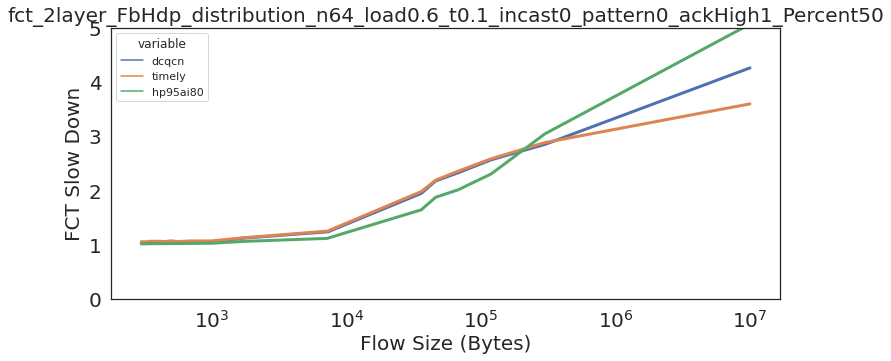

In [681]:
import subprocess
import argparse

def get_pctl(a, p):
    i = int(len(a) * p)
    return a[i]

def get_results_df(cc, prefix, percent = 50):
    work_dir = "/home/cxyzhao/High-Precision-Congestion-Control/analysis/"
    cmd = 'python {}/fct_analysis.py -c {} -p {}'.format(work_dir, cc, prefix)
    x = subprocess.check_output(cmd, shell=True)
    lines = x.decode().split("\n")
    find_fct = False
    fsize_lst = []
    fct_lst = []
    for line in lines:
        if len(line) == 0:
            continue
        if(line.find('FCT') != -1):
            find_fct = True
        elif (find_fct):
            fsize_lst.append(int(line.split(',')[0]))
            percent_to_idx = {50:1, 95:2, 99:3}
            fct_lst.append(float(line.split(',')[percent_to_idx[percent]]))
    
    #generate DataFrame
    lst = {}     
    lst["FlowSize"] = fsize_lst
    fct_name = cc
    lst[fct_name] = fct_lst
    return pd.DataFrame(lst)
    

def concat_df(df_lst):
    df = df_lst[0]
    for i in range(1, len(df_lst)):
        df = pd.concat([df, df_lst[i]])
    return df
    

percent = 50
df_lst = []
prefix = "fct_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1"
for cc in ["dcqcn", 
           "timely", 
           "hp95ai80", ]:
#            "abcdt0.0dl12000.0token50eta0.95", 
#            "aabcdt0.0dl12000.0token50eta0.95",
#           "rabcdt0.0dl12000.0token50eta0.95"]:
    df_lst.append(get_results_df(cc=cc, prefix=prefix))

df = concat_df(df_lst)


sns.set(rc={'figure.figsize':(12,5)})
sns.set_style('white')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
g= sns.lineplot('FlowSize', 'value', hue='variable', 
             data=pd.melt(df, 'FlowSize'), linewidth = 3)
g.set_title("{}_Percent{}".format(prefix, percent), fontsize = 20)
g.set_xscale('log')
g.set(ylim=(0, 5))
g.set_xlabel("Flow Size (Bytes)", fontsize = 20)
g.set_ylabel("FCT Slow Down", fontsize = 20)





/home/cxyzhao/.local/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


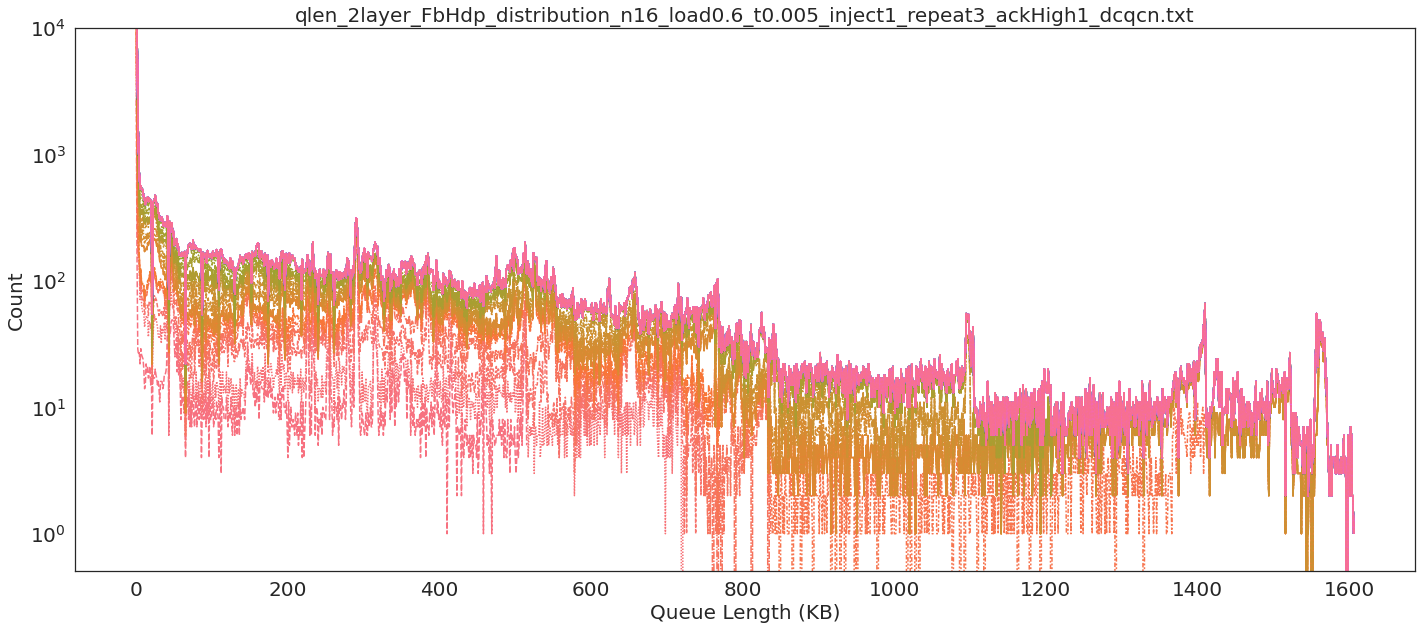

In [329]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

qlen_dir = "/home/cxyzhao/High-Precision-Congestion-Control/simulation/mix/"
#qlen_name = "qlen_2layer_FbHdp_distribution_n16_load0.6_t0.005_inject1_repeat3_ackHigh1_hp95ai80.txt"
qlen_name = "qlen_2layer_FbHdp_distribution_n16_load0.6_t0.005_inject1_repeat3_ackHigh1_dcqcn.txt"
#qlen_name = "qlen_2layer_FbHdp_distribution_n16_load0.6_t0.005_inject1_repeat3_ackHigh1_aabcdt0.0dl16000.0token50eta0.95.txt"
qlen_file = qlen_dir + qlen_name
port_to_qlenDist = {}
with open(qlen_file) as f:
    lines =f.readlines()
    for line in lines:
        if line.find("time") != -1:
            continue
        else:
            lst = line.split()
            lst = [int(i) for i in lst]
            name = "switch{}port{}".format(lst[0], lst[1])
            if name not in port_to_qlenDist.keys():
                port_to_qlenDist[name] = []
            port_to_qlenDist[name].append(lst[2:])


sns.set(rc={'figure.figsize':(24,10)})
sns.set_style('white')

#g.set_yticks([5000 * (i+1) for i in range(8)])

#g.set_yticklabels(g.get_yticks(), size=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
df = pd.DataFrame(port_to_qlenDist["switch64port2"]).T
g= sns.lineplot(data=df)
g.set_title(qlen_name, fontsize = 20)
g.set_yscale('log')
g.set_xlabel("Queue Length (KB)", fontsize = 20)
g.set_ylabel("Count", fontsize = 20)
g.set(ylim=(0, 10000))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend([],[], frameon=False)


[(0.0, 200.0)]

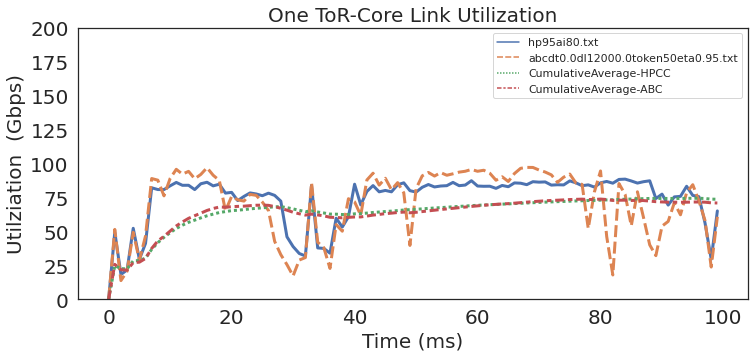

In [580]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def tranfer_name(cc_name):
    cc_name = cc_name.replace("aabc", "pw-abc")
    cc_name = cc_name.replace("rabc", "wr-abc")
    return cc_name

link_dir = "/home/cxyzhao/High-Precision-Congestion-Control/simulation/mix/"
#link_name = "link_2layer_FbHdp_distribution_n16_load0.6_t0.005_inject1_repeat3_ackHigh1_hp95ai80.txt"

# link_name_lst = ["link_2layer_FbHdp_distribution_n16_load0.6_t0.005_inject1_repeat3_ackHigh1_abcdt0.0dl16000.0token50eta0.95.txt",
#                 "link_2layer_FbHdp_distribution_n16_load0.6_t0.005_inject1_repeat3_ackHigh1_hp95ai80.txt",
#                 "link_2layer_FbHdp_distribution_n16_load0.6_t0.005_inject1_repeat3_ackHigh1_aabcdt0.0dl16000.0token50eta0.95.txt"]
link_name_lst = ["link_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1_hp95ai80.txt",
                 "link_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1_abcdt0.0dl12000.0token50eta0.95.txt",]
                 #"link_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1_aabcdt0.0dl12000.0token50eta0.95.txt",]
                 #"link_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1_aabcdt0.0dl12000.0token50eta0.95.txt",
                 #"link_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1_rabcdt0.0dl12000.0token50eta0.95.txt"]
#                  "link_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1_abcdt0.0dl12000.0token50eta0.95.txt",
#                  "link_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1_abcdt0.0dl12000.0token50eta1.3.txt",
#                  "link_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1_hp95ai80.txt"]
df =pd.DataFrame()

for link_name in link_name_lst:
    link_file = link_dir + link_name
    cc_name  = link_name[74:]
    port_to_linkutil_series = {}
    with open(link_file) as f:
        lines =f.readlines()
        for line in lines:
            if line.find("time") != -1:
                continue
            else:
                lst = line.split()
                lst = [float(i) for i in lst]
                name = "switch{}port{}".format(int(lst[0]), int(lst[1]))
                if name not in port_to_linkutil_series.keys():
                    port_to_linkutil_series[name] = []
                port_to_linkutil_series[name].append(lst[2])


    cc_name  = tranfer_name(cc_name)
    df = pd.concat([df, pd.DataFrame(port_to_linkutil_series["switch64port14"], columns=[cc_name]) ], axis=1)




#df['Cumulative Moving Average'] = df.expanding().mean()
accu_avg = df.expanding().mean()
accu_avg.columns = ["CumulativeAverage-HPCC", "CumulativeAverage-ABC"]

df = pd.concat([df, accu_avg])
sns.set(rc={'figure.figsize':(12,5)})
sns.set_style('white')

#g.set_yticks([5000 * (i+1) for i in range(8)])

#g.set_yticklabels(g.get_yticks(), size=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
g= sns.lineplot(data=df, linewidth = 3)
g.set_title("One ToR-Core Link Utilization", fontsize = 20)
g.set_xlabel("Time (ms)", fontsize = 20)
g.set_ylabel("Utilziation  (Gbps)", fontsize = 20)
g.set(ylim=(0, 200))
# g.set(xlim=(0, 30))
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.legend([],[], frameon=False)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


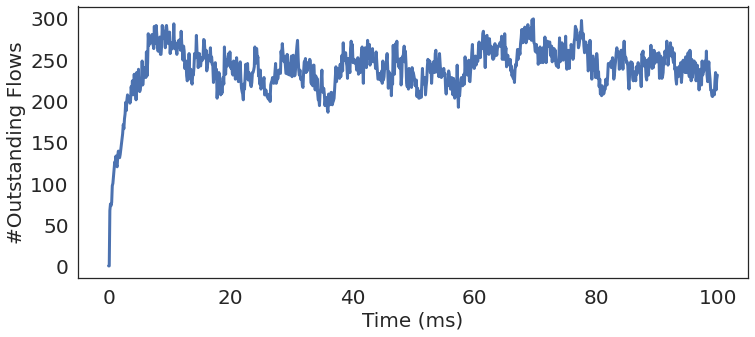

In [579]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def tranfer_name(cc_name):
    cc_name = cc_name.replace("aabc", "pw-abc")
    cc_name = cc_name.replace("rabc", "wr-abc")
    return cc_name

file_dir = "/home/cxyzhao/High-Precision-Congestion-Control/simulation/mix/"
file_name_lst = ["outflow_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1_abcdt0.0dl12000.0token50eta0.95.txt"]
df =pd.DataFrame()

for file_name in file_name_lst:
    _file = file_dir + file_name
    cc_name  = _file[74:]
    counters = []
    with open(_file) as f:
        lines =f.readlines()
        #cur_counter  = [0 for i in range(64)]
        cur_counter = 0
        for line in lines:
            if line.find("time") != -1:
                counters.append(cur_counter)
                #cur_counter  = [0 for i in range(64)]
                cur_counter = 0
                continue
            else:
                lst = line.split()
                if(len(lst) < 3):
                    continue
                lst = [int(i) for i in lst]
                cur_counter += lst[2]


    cc_name  = tranfer_name(cc_name)
    cc_name = "ABC"
    df = pd.concat([df, pd.DataFrame(counters, columns=[cc_name]) ], axis=1)



df['Cumulative Moving Average'] = df.expanding().mean()

sns.set(rc={'figure.figsize':(12,5)})
sns.set_style('white')

#g.set_yticks([5000 * (i+1) for i in range(8)])

#g.set_yticklabels(g.get_yticks(), size=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
g= sns.lineplot(data=df, x=df.index * 0.1, y='ABC', linewidth = 3)
#g.set_title("#Outstanding Flows", fontsize = 20)
g.set_xlabel("Time (ms)", fontsize = 20)
g.set_ylabel("#Outstanding Flows", fontsize = 20)
# g.set(ylim=(0, 100))
# g.set(xlim=(0, 30))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend([],[], frameon=False)

